In [22]:
# What drives happiness?
# What are the factors that influence suicide rate?

# import dependencies
from config import census_key
import requests
from pprint import pprint
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Get census data using api

vars_full = {
    'B19001_001E': 'Household income',
#     'B19083_001E': 'GINI INDEX OF INCOME INEQUALITY',
#     'B19202_001E': 'MEDIAN NONFAMILY HOUSEHOLD INCOME',
    'B15001_044E': 'Estimate!!Total!!Female!!18 to 24 years',
    'B15001_003E': 'Estimate!!Total!!Male!!18 to 24 years',
    'B15001_046E': 'Estimate!!Total!!Female!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_005E': 'Estimate!!Total!!Male!!18 to 24 years!!9th to 12th grade no diploma',
    'B01003_001E': 'Total population'
}
vars = list(vars_full.keys())

In [3]:
url_start = 'https://api.census.gov/data/2017/acs/acs5?get='
url_mid = 'NAME,' + ','.join(vars)
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)

In [4]:
df = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df['state'] + df['county']
county_code = [code.lstrip('0') for code in county_code]
df['County Code'] = county_code
df = df.set_index('County Code')

# # Find Yolo County. Codes here: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
# df.loc[(df['state'] == '06') & (df['county'] == '113')]

In [5]:
# Import suicide rates csv
path_csv = 'suicide_rates.csv'
df_grim = pd.read_csv(path_csv)
# convert county code column to string
df_grim['County Code'] = df_grim['County Code'].astype(str)
df_grim = df_grim.set_index('County Code')
# Calculate suicide rate per 100k
df_grim['Suicide Rate'] = df_grim['Deaths'] / df_grim['Population'] *100000 

In [55]:
# Join census and suicide dataframes
df_full = df.join(df_grim, on='County Code', how='inner')

# convert numerical columns into float
for thisVar in vars:
    df_full[thisVar] = [float(i) for i in df_full[thisVar]]

df_full.head()

,NAME,B17001_002E,B19001_001E,B19083_001E,B19202_001E,B15001_044E,B15001_003E,B15001_046E,B15001_005E,B01003_001E,state,county,County,Deaths,Population,Suicide Rate
County Code,,,,,,,,,,,,,,,,
1099,"Monroe County, Alabama",7249.0,8207.0,0.5568,11690.0,928.0,952.0,110.0,95.0,21745.0,01,099,"Monroe County, AL",15,108713,13.797798
1079,"Lawrence County, Alabama",5490.0,13056.0,0.4317,20317.0,1311.0,1365.0,184.0,263.0,33288.0,01,079,"Lawrence County, AL",30,166472,18.021049
1081,"Lee County, Alabama",33132.0,59001.0,0.5008,23393.0,14786.0,15520.0,854.0,1002.0,156597.0,01,081,"Lee County, AL",94,782776,12.008544
1093,"Marion County, Alabama",5175.0,12453.0,0.4734,17608.0,1115.0,1186.0,154.0,343.0,30058.0,01,093,"Marion County, AL",28,150604,18.591804
1073,"Jefferson County, Alabama",113368.0,261390.0,0.5010,30234.0,30495.0,29738.0,2616.0,3773.0,659460.0,01,073,"Jefferson County, AL",449,3299357,13.608712


Text(0, 0.5, 'Count')

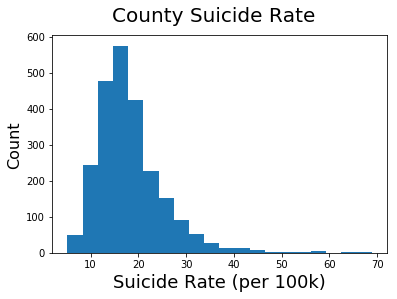

In [56]:
n_bins = 20
fig = plt.figure()
plt.hist(y, bins=n_bins)
fig.suptitle('County Suicide Rate', fontsize=20)
plt.xlabel('Suicide Rate (per 100k)', fontsize=18)
plt.ylabel('Count', fontsize=16)

Slope = 33.98870972851766
r-squared = 0.08624282158322398
p-value = 3.3573445632114665e-48


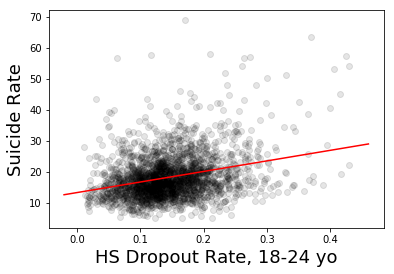

In [64]:
# Define x and y
x = (df_full['B15001_005E'] + df_full['B15001_046E']) / (df_full['B15001_003E'] + df_full['B15001_044E'])
y = df_full['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
# axes.set_xlim([0,500000])
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('HS Dropout Rate, 18-24 yo', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = -0.00019397479934535737
r-squared = 0.05551276250480331
p-value = 3.728708605317654e-31


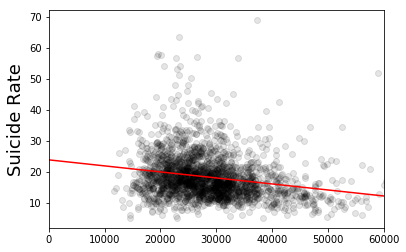

In [72]:
# Define x and y
x = df_full['B19202_001E'] # 'MEDIAN NONFAMILY HOUSEHOLD INCOME'
y = df_full['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
axes.set_xlim([0,60000])
plt.ylabel('Suicide Rate', fontsize=18)
# plt.xlabel('HS Dropout Rate, 18-24 yo', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")